# Regularization

Regularization is a umbrella term that refers to approaches that help reduce the chance of overfitting, usually either by normalization or through added penatlies.

### 1. Ridge regression ($L_2$ regularization)

Perhaps the most common form of regularization is known as *ridge regression* or $L_2$ *regularization*, sometimes also called *Tikhonov regularization*. This proceeds by penalizing the sum of squares (2-norms) of the model coefficients; in this case, the penalty on the model fit would be 

$$ J(\theta) =  \frac{1}{2}\sum_{i=1}^m(h_\theta(x^{(i)}) - y^{(i)})^2 + \lambda\sum_{j=1}^n \boldsymbol{\theta}_j^2$$

where $\lambda$ is a free parameter that controls the strength of the penalty.

### 2. Lasso regression ($L_1$ regularization)

Another very common type of regularization is known as lasso, and involves penalizing the sum of absolute values (1-norms) of regression coefficients:

$$ J(\theta) = \frac{1}{2}\sum_{i=1}^m(h_\theta(x^{(i)}) - y^{(i)})^2+ \lambda\sum_{j=1}^n |\theta_j|$$

Though this is conceptually very similar to ridge regression, the results can differ surprisingly: that is, lasso regression can set certain features to zero, while ridge regression focuses on shrinking all parameters so it is not overly reliant on one feature.

### 3. Elastic net 

When you lack domain knowledge, you can simply use elastic net.

$$
J(\theta) = \frac{1}{2}\sum_{i=1}^m(h_\theta(x^{(i)}) - y^{(i)})^2 + \lambda \sum_{j=1}^n |\theta_k| + (1 - \lambda) \sum_{k=1}^n \theta_j^2
$$



### Ridge or Lasso or Elastic net??

Regularization should be ALMOST ALWAYS used, since these techniques reduces overfitting.

How to choose is a little bit difficult. It is easier to understand the assumptions behind.
1.  Ridge assumes that coefficients are normally distributed.   **Thus, if you don't want any feature to dominate too much, use Ridge.**
2. Lasso assumes that coefficients are Laplace distributed (in layman sense, it mean some predictors are very useful while some are completely irrelevant).   Here, Lasso has the ability to shrink coefficient to zero thus eliminate predictors that are not useful to the output, thus automatic feature selection.  **In simple words, if you have only very few predictors with medium/large effect, use Lasso.**
3.  Elastic basically is a compromise between the two, and thus take huge computation time to reach that compromise.  **If you have the resource to spare, you can use Elastic net**


## Code

In [2]:
#experiment tracking
import mlflow
import os
# This the dockerized method.
# We build two docker containers, one for python/jupyter and another for mlflow.
# The url `mlflow` is resolved into another container within the same composer.
mlflow.set_tracking_uri("http://localhost:5000")
# In the dockerized way, the user who runs this code will be `root`.
# The MLflow will also log the run user_id as `root`.
# To change that, we need to set this environ["LOGNAME"] to your name.
os.environ["LOGNAME"] = "pooh"
# mlflow.create_experiment(name="chaky-diabetes-example")  #create if you haven't create
mlflow.set_experiment(experiment_name="pooh-regularization-experiments")



2023/09/11 17:16:17 INFO mlflow.tracking.fluent: Experiment with name 'pooh-regularization-experiments' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/191373597521052669', creation_time=1694427377675, experiment_id='191373597521052669', last_update_time=1694427377675, lifecycle_stage='active', name='pooh-regularization-experiments', tags={}>

## quick load and preprocessing

In [3]:

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from time import time
import pickle

df = pd.read_csv("../car_price/datasets/Cars.csv")

# clean data
df['max_power'] = df['max_power'].str.extract(r'([\d.]+)').astype(float)
df['engine'] = df['engine'].str.extract('(\d+)').astype(float).astype(pd.Int64Dtype(), errors='ignore')
df['mileage'] = df['mileage'].str.extract(r'([\d.]+)').astype(float)

feature_names = ['engine','max_power','mileage','year']

X = df[feature_names]
y = df["selling_price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 96)

#preprocessing
# permutation
X_train['engine'].fillna(X_train['engine'].median(), inplace=True)
X_train['max_power'].fillna(X_train['max_power'].mean(), inplace=True)
X_train['mileage'].fillna(X_train['mileage'].mean(),inplace=True)

X_test['engine'].fillna(X_test['engine'].median(), inplace=True)
X_test['max_power'].fillna(X_test['max_power'].mean(), inplace=True)
X_test['mileage'].fillna(X_test['mileage'].mean(), inplace=True)

# log tranform y
y_train = np.log(y_train)

# to numpy
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()



scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

model_path = f"models/"

if not os.path.exists(model_path):
    os.makedirs(model_path)

with open(model_path+"scaler.pkl", 'wb') as file:
    pickle.dump(scaler, file)


# actually you can do like this too
# X = np.insert(X, 0, 1, axis=1)

feature_names =  feature_names  
intercept = np.ones((X_train.shape[0], 1))
X_train   = np.concatenate((intercept, X_train), axis=1)
intercept = np.ones((X_test.shape[0], 1))
X_test    = np.concatenate((intercept, X_test), axis=1)

In [4]:
from math import sqrt
from random import randrange

def Xavier_initw(n_feature):
    lower , upper = -(1.0 / sqrt(n_feature)), (1.0 / sqrt(n_feature))

    numbers = np.random.randint(0,1000,n_feature)
    scaled = lower + (numbers * (upper - lower))/1000

    # numbers =  np.random.rand(n_feature)
    # scaled = lower + (numbers * (upper - lower))
    
    return scaled
    

In [5]:
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures



class LinearRegression(object):
    
    #in this class, we add cross validation as well for some spicy code....
    kfold = KFold(n_splits=3)
            
    def __init__(self, 
                regularization, 
                lr=0.001, 
                method='batch',
                num_epochs=1000, 
                batch_size=50, 
                cv=kfold,
                momentum =0 ,
                inintw_method="xavier",
                patience = 10):

        self.lr         = lr
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.method     = method
        self.initw      = inintw_method
        self.cv         = cv
        self.regularization = regularization
        self.momentum    = momentum
        self.patience = patience


    def mse(self, ytrue, ypred):
        return ((ypred - ytrue) ** 2).sum() / ytrue.shape[0]

    def r2(self, ytrue, ypred):
        return 1-(((ypred - ytrue) ** 2).sum() / ((ytrue.mean() - ytrue) ** 2).sum())
    
    def fit(self, X_train, y_train, feature_names):
            
        #create a list of kfold scores
        self.kfold_scores = list()
        
        #reset val loss
        self.val_loss_old = np.infty

        self.cols = feature_names

        
        #kfold.split in the sklearn.....
        #5 splits
        for fold, (train_idx, val_idx) in enumerate(self.cv.split(X_train)):
            
            X_cross_train = X_train[train_idx]
            y_cross_train = y_train[train_idx]
            X_cross_val   = X_train[val_idx]
            y_cross_val   = y_train[val_idx]


            
            if self.initw =="xavier":
                self.theta = Xavier_initw(X_cross_train.shape[1])
            else:
                self.theta = np.zeros(X_cross_train.shape[1])

            self.p_step = 0

            no_improvement_count = 0


            #define X_cross_train as only a subset of the data
            #how big is this subset?  => mini-batch size ==> 50
            
            #one epoch will exhaust the WHOLE training set
            with mlflow.start_run(run_name=f"Fold-{fold}", nested=True):
                
                
                params = {"method": self.method, "lr": self.lr, "reg": type(self).__name__,
                          "initial weight method":self.initw,"momentum":self.momentum}
                mlflow.log_params(params=params)
                
                for epoch in range(self.num_epochs):
                
                    #with replacement or no replacement
                    #with replacement means just randomize
                    #with no replacement means 0:50, 51:100, 101:150, ......300:323
                    #shuffle your index
                    perm = np.random.permutation(X_cross_train.shape[0])
                            
                    X_cross_train = X_cross_train[perm]
                    y_cross_train = y_cross_train[perm]
                    
                    if self.method == 'sto':
                        for batch_idx in range(X_cross_train.shape[0]):
                            X_method_train = X_cross_train[batch_idx].reshape(1, -1) #(11,) ==> (1, 11) ==> (m, n)
                            y_method_train = y_cross_train[batch_idx].reshape(1,)
                            train_loss = self._train(X_method_train,y_method_train)

                    elif self.method == 'mini':
                        for batch_idx in range(0, X_cross_train.shape[0], self.batch_size):
                            #batch_idx = 0, 50, 100, 150
                            X_method_train = X_cross_train[batch_idx:batch_idx+self.batch_size, :]
                            y_method_train = y_cross_train[batch_idx:batch_idx+self.batch_size]
                            train_loss = self._train(X_method_train, y_method_train)

                    else:
                        X_method_train = X_cross_train
                        y_method_train = y_cross_train
                        train_loss = self._train(X_method_train, y_method_train)

                    mlflow.log_metric(key="train_loss", value=train_loss, step=epoch)

                    yhat_val = self.predict(X_cross_val)
                    val_loss_new = self.mse(y_cross_val, yhat_val)
                    mlflow.log_metric(key="val_loss", value=val_loss_new, step=epoch)

                    #record dataset
                    # mlflow_train_data = mlflow.data.from_numpy(features=X_method_train, targets=y_method_train)
                    # mlflow.log_input(mlflow_train_data, context="training")
                    
                    # mlflow_val_data = mlflow.data.from_numpy(features=X_cross_val, targets=y_cross_val)
                    # mlflow.log_input(mlflow_val_data, context="validation")
                    
                    #early stopping
                    if np.allclose(val_loss_new, self.val_loss_old):
                        self.no_improvement_count += 1
                        if no_improvement_count >= self.patience and epoch>0.1*self.num_epochs:
                            print("finish epoch: ",epoch)
                            break
                    else:
                        self.no_improvement_count = 0

                    self.val_loss_old = val_loss_new
            
                self.kfold_scores.append(val_loss_new)
                print(f"Fold {fold}: {val_loss_new}")
            
                    
    def _train(self, X, y):
        yhat = self.predict(X)
        m    = X.shape[0]
        grad = (1/m) * X.T @(yhat - y) + self.regularization.derivation(self.theta)
        step = self.lr * grad
        
        self.theta = self.theta - step + self.momentum * self.p_step
        
        self.p_step = step
        
        return self.mse(y, yhat)
    
    def predict(self, X):
        return X @ self.theta  #===>(m, n) @ (n, )
    
    def _coef(self):
        return self.theta[1:]  #remind that theta is (w0, w1, w2, w3, w4.....wn)
                               #w0 is the bias or the intercept
                               #w1....wn are the weights / coefficients / theta
    def _bias(self):
        return self.theta[0]

    def plot_coef(self):

        coefs = pd.DataFrame(
        self._coef(), columns=["Coefficients"], index=self.cols
        )

        coefs.plot(kind="barh", figsize=(9, 7))
        plt.title("Feature importance")
        plt.axvline(x=0, color=".5")
        plt.subplots_adjust(left=0.3)
        plt.show()

        

Now we can create `Ridge`, `Lasso` and `Elastic` class that extends the `LinearRegression`, with added penalty.

In [6]:
class PolynomialPenalty:
    
    def __init__(self, l):
        self.l = l # lambda value
        
    def __call__(self, theta): #__call__ allows us to call class as method
        return 0
        
    def derivation(self, theta):
        return 0
    
class NormalPenalty:
    
    def __init__(self, l):
        self.l = l # lambda value
        
    def __call__(self, theta): #__call__ allows us to call class as method
        return 0
        
    def derivation(self, theta):
        return 0


class LassoPenalty:
    
    def __init__(self, l):
        self.l = l # lambda value
        
    def __call__(self, theta): #__call__ allows us to call class as method
        return self.l * np.sum(np.abs(theta))
        
    def derivation(self, theta):
        return self.l * np.sign(theta)
    
class RidgePenalty:
    
    def __init__(self, l):
        self.l = l
        
    def __call__(self, theta): #__call__ allows us to call class as method
        return self.l * np.sum(np.square(theta))
        
    def derivation(self, theta):
        return self.l * 2 * theta

class ElasticPenalty:
    
    def __init__(self, l = 0.1, l_ratio = 0.5):
        self.l = l 
        self.l_ratio = l_ratio

    def __call__(self, theta):  #__call__ allows us to call class as method
        l1_contribution = self.l_ratio * self.l * np.sum(np.abs(theta))
        l2_contribution = (1 - self.l_ratio) * self.l * 0.5 * np.sum(np.square(theta))
        return (l1_contribution + l2_contribution)

    def derivation(self, theta):
        l1_derivation = self.l * self.l_ratio * np.sign(theta)
        l2_derivation = self.l * (1 - self.l_ratio) * theta
        return (l1_derivation + l2_derivation)

class Polynomial(LinearRegression):
    
    def __init__(self, method, lr, l,momentum=0,initw="xavier",patience = 10,num_epochs = 500):
        self.regularization = PolynomialPenalty(l)
        super().__init__(regularization = self.regularization,lr= lr,method = method,momentum=momentum,inintw_method= initw,patience=patience,num_epochs =num_epochs)

class Normal(LinearRegression):
    
    def __init__(self, method, lr, l,momentum=0,initw="xavier",patience = 10,num_epochs = 500):
        self.regularization = NormalPenalty(l)
        super().__init__(regularization = self.regularization,lr= lr,method = method,momentum=momentum,inintw_method= initw,patience=patience,num_epochs =num_epochs)
    
class Lasso(LinearRegression):
    
    def __init__(self, method, lr, l,momentum=0,initw="xavier",patience = 10,num_epochs = 500):
        self.regularization = LassoPenalty(l)
        super().__init__(regularization = self.regularization,lr= lr,method = method,momentum=momentum,inintw_method= initw,patience=patience,num_epochs =num_epochs)
        
class Ridge(LinearRegression):
    
    def __init__(self, method, lr, l,momentum=0,initw="xavier",patience = 10,num_epochs = 500):
        self.regularization = RidgePenalty(l)
        super().__init__(regularization = self.regularization,lr= lr,method = method,momentum=momentum,inintw_method= initw,patience=patience,num_epochs =num_epochs)
        
class ElasticNet(LinearRegression):
    
    def __init__(self, method, lr, l, l_ratio=0.5,momentum=0,initw="xavier",patience = 10,num_epochs = 500):
        self.regularization = ElasticPenalty(l, l_ratio)
        super().__init__(regularization = self.regularization,lr= lr,method = method,momentum=momentum,inintw_method= initw,patience=patience,num_epochs =num_epochs)


## Experiment

Use cross-validation to compare (1) polynomial, lasso, ridge, normal; (2) with or without momentum;
(3) stochastic, mini-batch, batch; (4) zero, xavier; (5) learning rate of 0.01, 0.001, and 0.0001

In [6]:
# Write a short report inside the jupyter notebook discussing your findings, together with some cap-
# tured screenshots of ML flow, and a final table depicting the comparisons.

In [7]:
#helper function for looping classnames
import sys

def str_to_class(classname):
    return getattr(sys.modules[__name__], classname)

In [8]:
# results
tables = []

## ALL combination

In [9]:
# default value
table = {"name":[],
            "mse":[],
            "r2":[]}



l = 0.06
p_degree = 2
patience = 10
num_epochs = 500

# experiments list
regs = ["Polynomial","Ridge","Lasso","Normal"]
momentums = [0.2,0]
methods = ["batch", "mini", "sto"]
init_methods = ["xavier","zero"]
lrs = [0.01,0.001,0.0001]


# change here
for reg in regs:
    for momentum in momentums:
        for method in methods:
            for init_method in init_methods:
                for lr in lrs:
                    
                    # change here 

                    params = {"method": method, "lr": lr, "l": l,"momentum": momentum,"initw":init_method,"patience":patience,"num_epochs":num_epochs}

                    if reg == "Polynomial":
                        run_name = f"method-{params['method']}-lr-{params['lr']}-momentum-{params['momentum']}-initw-{params['initw']}-reg-Polynomial-degree-{p_degree}"
                    else:
                        run_name = f"method-{params['method']}-lr-{params['lr']}-momentum-{params['momentum']}-initw-{params['initw']}-reg-{reg}"
                        
                    print(run_name)
                    print("-"*len(run_name))
                    table["name"].append(reg)
                    mlflow.start_run(run_name=run_name, nested=True)

                    # #######
                    if reg == "Polynomial":


                        poly = PolynomialFeatures(degree = p_degree, include_bias=True)

                        X_train_tran = scaler.inverse_transform(X_train[:,1:])
                        X_test_tran  = scaler.inverse_transform(X_test[:,1:])
                        
                        X_train_tran = poly.fit_transform(X_train_tran)
                        X_test_tran = poly.fit_transform(X_test_tran)

                        scaler_poly = StandardScaler()
                        X_train_tran = scaler_poly.fit_transform(X_train_tran)
                        X_test_tran  = scaler_poly.transform(X_test_tran)

                        model_path = f"models/"

                        if not os.path.exists(model_path):
                            os.makedirs(model_path)

                        with open(model_path+f"scaler_poly{p_degree}.pkl", 'wb') as file:
                            pickle.dump(scaler_poly, file)

                        feature_names_tran = poly.get_feature_names_out(feature_names)[1:]

                    else:
                        
                        X_train_tran = X_train.copy()   
                        X_test_tran = X_test.copy()
                        feature_names_tran = feature_names


                    # 
                    if reg == "Ridge":
                        params["l"] = params["l"]*0.3


                    type_of_regression = str_to_class(reg)    #Ridge, Lasso, ElasticNet
                    model = type_of_regression(**params)


                    model.fit(X_train_tran, y_train,feature_names_tran)



                    yhat = model.predict(X_test_tran)
                    yhat = np.exp(yhat)
                    mse  = model.mse(yhat, y_test)
                    r2  = model.r2(yhat, y_test)

                    print("Test MSE: ", mse)
                    print("Test R2: ", r2)

                    table["mse"].append(mse)
                    table["r2"].append(r2)



                    mlflow.log_metric(key="test_mse", value=mse)
                    mlflow.log_metric(key="test_r2", value=r2)

                    signature = mlflow.models.infer_signature(X_train_tran, model.predict(X_train_tran))
                    mlflow.sklearn.log_model(model, artifact_path='model', signature=signature)

                    # #######

                    mlflow.end_run()



method-batch-lr-0.01-momentum-0.2-initw-xavier-reg-Polynomial-degree-2
----------------------------------------------------------------------
Fold 0: 168.6453378189604
Fold 1: 169.05782947725987
Fold 2: 168.68627474482273
Test MSE:  952049115765.6058
Test R2:  -148191188233.29123
method-batch-lr-0.001-momentum-0.2-initw-xavier-reg-Polynomial-degree-2
-----------------------------------------------------------------------
Fold 0: 168.25108989437223
Fold 1: 169.16523113417148
Fold 2: 168.72490456387354
Test MSE:  952049478500.3595
Test R2:  -164639936826.41415


c:\Users\ASUS\anaconda3\envs\ML_env\lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\ASUS\anaconda3\envs\ML_env\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


method-batch-lr-0.0001-momentum-0.2-initw-xavier-reg-Polynomial-degree-2
------------------------------------------------------------------------
Fold 0: 169.12832976810995
Fold 1: 169.33296642973002
Fold 2: 169.08966356431281
Test MSE:  952052326587.9978
Test R2:  -3217146979879.414


c:\Users\ASUS\anaconda3\envs\ML_env\lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\ASUS\anaconda3\envs\ML_env\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


method-batch-lr-0.01-momentum-0.2-initw-zero-reg-Polynomial-degree-2
--------------------------------------------------------------------
Fold 0: 168.70103250532023
Fold 1: 169.06971189490204
Fold 2: 168.69730289429097
Test MSE:  952048990497.9884
Test R2:  -129627037708.03362


c:\Users\ASUS\anaconda3\envs\ML_env\lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\ASUS\anaconda3\envs\ML_env\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


method-batch-lr-0.001-momentum-0.2-initw-zero-reg-Polynomial-degree-2
---------------------------------------------------------------------
Fold 0: 168.24419631042497
Fold 1: 169.08037718082304
Fold 2: 168.58253445983186
Test MSE:  952050423328.6604
Test R2:  -410583357219.4811


c:\Users\ASUS\anaconda3\envs\ML_env\lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\ASUS\anaconda3\envs\ML_env\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


method-batch-lr-0.0001-momentum-0.2-initw-zero-reg-Polynomial-degree-2
----------------------------------------------------------------------
Fold 0: 168.53992406924718
Fold 1: 169.21441463758222
Fold 2: 168.8635368812077
Test MSE:  952052407424.2697
Test R2:  -33100758246854.55


c:\Users\ASUS\anaconda3\envs\ML_env\lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\ASUS\anaconda3\envs\ML_env\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


method-mini-lr-0.01-momentum-0.2-initw-xavier-reg-Polynomial-degree-2
---------------------------------------------------------------------
Fold 0: 170.97708417113085
Fold 1: 169.57657012059144
Fold 2: 168.84026662594593
Test MSE:  952038626694.7404
Test R2:  -2861885826.0509443


c:\Users\ASUS\anaconda3\envs\ML_env\lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\ASUS\anaconda3\envs\ML_env\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


method-mini-lr-0.001-momentum-0.2-initw-xavier-reg-Polynomial-degree-2
----------------------------------------------------------------------
Fold 0: 169.67021776276303
Fold 1: 169.24476958033148
Fold 2: 168.78766644926176
Test MSE:  952047326246.2719
Test R2:  -36129024654.82104


c:\Users\ASUS\anaconda3\envs\ML_env\lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\ASUS\anaconda3\envs\ML_env\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


method-mini-lr-0.0001-momentum-0.2-initw-xavier-reg-Polynomial-degree-2
-----------------------------------------------------------------------
Fold 0: 168.56208745547139
Fold 1: 169.10014944926874
Fold 2: 168.6817070913716
Test MSE:  952049166780.4016
Test R2:  -163120553243.8545


c:\Users\ASUS\anaconda3\envs\ML_env\lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\ASUS\anaconda3\envs\ML_env\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


method-mini-lr-0.01-momentum-0.2-initw-zero-reg-Polynomial-degree-2
-------------------------------------------------------------------
Fold 0: 169.81105980544393
Fold 1: 169.58185733498837
Fold 2: 169.12206833937722
Test MSE:  952050528869.412
Test R2:  -366668291745.36597


c:\Users\ASUS\anaconda3\envs\ML_env\lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\ASUS\anaconda3\envs\ML_env\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


method-mini-lr-0.001-momentum-0.2-initw-zero-reg-Polynomial-degree-2
--------------------------------------------------------------------
Fold 0: 169.62351420320988
Fold 1: 169.2773767739169
Fold 2: 168.76320822744196
Test MSE:  952046878667.4551
Test R2:  -27032017774.723957


c:\Users\ASUS\anaconda3\envs\ML_env\lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\ASUS\anaconda3\envs\ML_env\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


method-mini-lr-0.0001-momentum-0.2-initw-zero-reg-Polynomial-degree-2
---------------------------------------------------------------------
Fold 0: 168.6441263706918
Fold 1: 169.05571041407185
Fold 2: 168.69019227684277
Test MSE:  952049062214.6688
Test R2:  -141008142452.45728


c:\Users\ASUS\anaconda3\envs\ML_env\lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\ASUS\anaconda3\envs\ML_env\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


method-sto-lr-0.01-momentum-0.2-initw-xavier-reg-Polynomial-degree-2
--------------------------------------------------------------------
Fold 0: 172.97461044042592
Fold 1: 175.48592167832356
Fold 2: 175.82871311998264
Test MSE:  952019421804.701
Test R2:  -152358.82954296962


c:\Users\ASUS\anaconda3\envs\ML_env\lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\ASUS\anaconda3\envs\ML_env\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


method-sto-lr-0.001-momentum-0.2-initw-xavier-reg-Polynomial-degree-2
---------------------------------------------------------------------
Fold 0: 170.5068371259318
Fold 1: 169.9491518437576
Fold 2: 170.41679181461052
Test MSE:  952007926408.8916
Test R2:  -395924298.92760414


c:\Users\ASUS\anaconda3\envs\ML_env\lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\ASUS\anaconda3\envs\ML_env\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


method-sto-lr-0.0001-momentum-0.2-initw-xavier-reg-Polynomial-degree-2
----------------------------------------------------------------------
Fold 0: 169.7131788053509
Fold 1: 169.5566994887708
Fold 2: 168.87887001950077
Test MSE:  952047117548.6476
Test R2:  -33347278411.78858


c:\Users\ASUS\anaconda3\envs\ML_env\lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\ASUS\anaconda3\envs\ML_env\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


method-sto-lr-0.01-momentum-0.2-initw-zero-reg-Polynomial-degree-2
------------------------------------------------------------------
Fold 0: 180.20968033050056
Fold 1: 175.4391427323182
Fold 2: 189.80775822562467
Test MSE:  5.420839780624212e+27
Test R2:  -0.0009334331877399737


c:\Users\ASUS\anaconda3\envs\ML_env\lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\ASUS\anaconda3\envs\ML_env\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


method-sto-lr-0.001-momentum-0.2-initw-zero-reg-Polynomial-degree-2
-------------------------------------------------------------------
Fold 0: 169.80675786746664
Fold 1: 171.29344457153275
Fold 2: 170.17104189925686
Test MSE:  952051725569.2284
Test R2:  -277333017556.1186


c:\Users\ASUS\anaconda3\envs\ML_env\lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\ASUS\anaconda3\envs\ML_env\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


method-sto-lr-0.0001-momentum-0.2-initw-zero-reg-Polynomial-degree-2
--------------------------------------------------------------------
Fold 0: 169.9531837280796
Fold 1: 169.71655000196802
Fold 2: 168.79124322520624
Test MSE:  952046605382.767
Test R2:  -23571013388.986523


c:\Users\ASUS\anaconda3\envs\ML_env\lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\ASUS\anaconda3\envs\ML_env\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


method-batch-lr-0.01-momentum-0-initw-xavier-reg-Polynomial-degree-2
--------------------------------------------------------------------
Fold 0: 168.83545455947817
Fold 1: 169.0620474226113
Fold 2: 168.6878277032677
Test MSE:  952049118897.1355
Test R2:  -153644197138.9929


c:\Users\ASUS\anaconda3\envs\ML_env\lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\ASUS\anaconda3\envs\ML_env\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


method-batch-lr-0.001-momentum-0-initw-xavier-reg-Polynomial-degree-2
---------------------------------------------------------------------
Fold 0: 168.27875505221806
Fold 1: 169.14488049580333
Fold 2: 168.72865871743377
Test MSE:  952049574511.1777
Test R2:  -128818253358.2683


c:\Users\ASUS\anaconda3\envs\ML_env\lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\ASUS\anaconda3\envs\ML_env\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


method-batch-lr-0.0001-momentum-0-initw-xavier-reg-Polynomial-degree-2
----------------------------------------------------------------------
Fold 0: 168.29096943644603
Fold 1: 169.80203879081972
Fold 2: 169.09613550931337
Test MSE:  952052477221.2299
Test R2:  -6922245895207.18


c:\Users\ASUS\anaconda3\envs\ML_env\lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\ASUS\anaconda3\envs\ML_env\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


method-batch-lr-0.01-momentum-0-initw-zero-reg-Polynomial-degree-2
------------------------------------------------------------------
Fold 0: 168.7875128456249
Fold 1: 169.08545680685432
Fold 2: 168.7066901466204
Test MSE:  952048886880.0247
Test R2:  -115724586416.18523


c:\Users\ASUS\anaconda3\envs\ML_env\lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\ASUS\anaconda3\envs\ML_env\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


method-batch-lr-0.001-momentum-0-initw-zero-reg-Polynomial-degree-2
-------------------------------------------------------------------
Fold 0: 168.26379339379767
Fold 1: 169.06393279573504
Fold 2: 168.58980120293137
Test MSE:  952050153529.2175
Test R2:  -324803457015.66815


c:\Users\ASUS\anaconda3\envs\ML_env\lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\ASUS\anaconda3\envs\ML_env\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


method-batch-lr-0.0001-momentum-0-initw-zero-reg-Polynomial-degree-2
--------------------------------------------------------------------
Fold 0: 168.50248109321146
Fold 1: 169.19619863252998
Fold 2: 168.82868154325487
Test MSE:  952052345730.2699
Test R2:  -21193444020558.24


c:\Users\ASUS\anaconda3\envs\ML_env\lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\ASUS\anaconda3\envs\ML_env\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


method-mini-lr-0.01-momentum-0-initw-xavier-reg-Polynomial-degree-2
-------------------------------------------------------------------
Fold 0: 169.89079109469222
Fold 1: 169.34751109144065
Fold 2: 168.99278500337576
Test MSE:  952048522104.5771
Test R2:  -76975303958.55534


c:\Users\ASUS\anaconda3\envs\ML_env\lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\ASUS\anaconda3\envs\ML_env\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


method-mini-lr-0.001-momentum-0-initw-xavier-reg-Polynomial-degree-2
--------------------------------------------------------------------
Fold 0: 169.6151924728879
Fold 1: 169.26693322960654
Fold 2: 168.79800521098667
Test MSE:  952047428241.2249
Test R2:  -37664670715.05966


c:\Users\ASUS\anaconda3\envs\ML_env\lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\ASUS\anaconda3\envs\ML_env\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


method-mini-lr-0.0001-momentum-0-initw-xavier-reg-Polynomial-degree-2
---------------------------------------------------------------------
Fold 0: 168.6827532115754
Fold 1: 169.07402033447997
Fold 2: 168.71352940669348
Test MSE:  952049001890.4047
Test R2:  -123610532179.3892


c:\Users\ASUS\anaconda3\envs\ML_env\lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\ASUS\anaconda3\envs\ML_env\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


method-mini-lr-0.01-momentum-0-initw-zero-reg-Polynomial-degree-2
-----------------------------------------------------------------
Fold 0: 172.02573117270447
Fold 1: 169.1231299025289
Fold 2: 169.16522146446323
Test MSE:  952049929684.4004
Test R2:  -184848410258.05933


c:\Users\ASUS\anaconda3\envs\ML_env\lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\ASUS\anaconda3\envs\ML_env\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


method-mini-lr-0.001-momentum-0-initw-zero-reg-Polynomial-degree-2
------------------------------------------------------------------
Fold 0: 169.68154701833984
Fold 1: 169.22457998414697
Fold 2: 168.78994021922122
Test MSE:  952047703693.3625
Test R2:  -41336747043.68405


c:\Users\ASUS\anaconda3\envs\ML_env\lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\ASUS\anaconda3\envs\ML_env\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


method-mini-lr-0.0001-momentum-0-initw-zero-reg-Polynomial-degree-2
-------------------------------------------------------------------
Fold 0: 168.70916083878427
Fold 1: 169.06915963003735
Fold 2: 168.69511608644927
Test MSE:  952048860722.7106
Test R2:  -117829468074.87117


c:\Users\ASUS\anaconda3\envs\ML_env\lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\ASUS\anaconda3\envs\ML_env\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


method-sto-lr-0.01-momentum-0-initw-xavier-reg-Polynomial-degree-2
------------------------------------------------------------------
Fold 0: 173.71519479264705
Fold 1: 177.08866760360365
Fold 2: 171.43695621516247
Test MSE:  949384416216.4357
Test R2:  -49417.436617453954


c:\Users\ASUS\anaconda3\envs\ML_env\lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\ASUS\anaconda3\envs\ML_env\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


method-sto-lr-0.001-momentum-0-initw-xavier-reg-Polynomial-degree-2
-------------------------------------------------------------------
Fold 0: 172.77128355329648
Fold 1: 168.91176034739476
Fold 2: 171.90982718339293
Test MSE:  952052512079.5479
Test R2:  -331175512218.798


c:\Users\ASUS\anaconda3\envs\ML_env\lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\ASUS\anaconda3\envs\ML_env\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


method-sto-lr-0.0001-momentum-0-initw-xavier-reg-Polynomial-degree-2
--------------------------------------------------------------------
Fold 0: 169.67183060051596
Fold 1: 169.2973976653444
Fold 2: 168.81132887254782
Test MSE:  952047194541.1361
Test R2:  -30223509244.386635


c:\Users\ASUS\anaconda3\envs\ML_env\lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\ASUS\anaconda3\envs\ML_env\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


method-sto-lr-0.01-momentum-0-initw-zero-reg-Polynomial-degree-2
----------------------------------------------------------------
Fold 0: 184.96058353256652
Fold 1: 187.1150680930634
Fold 2: 172.45590011689498
Test MSE:  929793147427.6229
Test R2:  -9.069498242779428


c:\Users\ASUS\anaconda3\envs\ML_env\lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\ASUS\anaconda3\envs\ML_env\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


method-sto-lr-0.001-momentum-0-initw-zero-reg-Polynomial-degree-2
-----------------------------------------------------------------
Fold 0: 169.7120554974206
Fold 1: 169.18316645546997
Fold 2: 169.691043316965
Test MSE:  952052148794.3787
Test R2:  -1715009392830.702


c:\Users\ASUS\anaconda3\envs\ML_env\lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\ASUS\anaconda3\envs\ML_env\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


method-sto-lr-0.0001-momentum-0-initw-zero-reg-Polynomial-degree-2
------------------------------------------------------------------
Fold 0: 170.3105531973823
Fold 1: 169.65808512696285
Fold 2: 168.87396655232345
Test MSE:  952041582343.8829
Test R2:  -6189084611.997266


c:\Users\ASUS\anaconda3\envs\ML_env\lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\ASUS\anaconda3\envs\ML_env\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


method-batch-lr-0.01-momentum-0.2-initw-xavier-reg-Ridge
--------------------------------------------------------
Fold 0: 0.5094930765162843
Fold 1: 0.5429893700925749
Fold 2: 0.5127166031752513
Test MSE:  358726006133.343
Test R2:  -2.783490302680901
method-batch-lr-0.001-momentum-0.2-initw-xavier-reg-Ridge
---------------------------------------------------------
Fold 0: 74.22081461456098
Fold 1: 77.54525325569256
Fold 2: 77.14116627894155
Test MSE:  951916147684.3593
Test R2:  -467932373.9147864
method-batch-lr-0.0001-momentum-0.2-initw-xavier-reg-Ridge
----------------------------------------------------------
Fold 0: 166.15177207690436
Fold 1: 158.11123583939778
Fold 2: 163.0661703055378
Test MSE:  952051984507.9751
Test R2:  -9800353220130.56
method-batch-lr-0.01-momentum-0.2-initw-zero-reg-Ridge
------------------------------------------------------
Fold 0: 0.5108661974762133
Fold 1: 0.5450181508728716
Fold 2: 0.5208764886576581
Test MSE:  337350740736.47345
Test R2:  -2.0677802

In [10]:
df_result = pd.DataFrame(table)
tables.append(df_result)
df_result

,name,mse,r2
0,Polynomial,9.520491e+11,-1.481912e+11
1,Polynomial,9.520495e+11,-1.646399e+11
2,Polynomial,9.520523e+11,-3.217147e+12
3,Polynomial,9.520490e+11,-1.296270e+11
4,Polynomial,9.520504e+11,-4.105834e+11
...,...,...,...
139,Normal,1.356647e+11,6.901419e-01
140,Normal,1.308775e+11,7.008381e-01
141,Normal,1.509304e+11,3.400696e-01
142,Normal,1.302738e+11,6.907632e-01


method-sto-lr-0.01-momentum-0-initw-xavier-reg-Normal
mse:  156104291456.188 r2:  0.7205509280395073


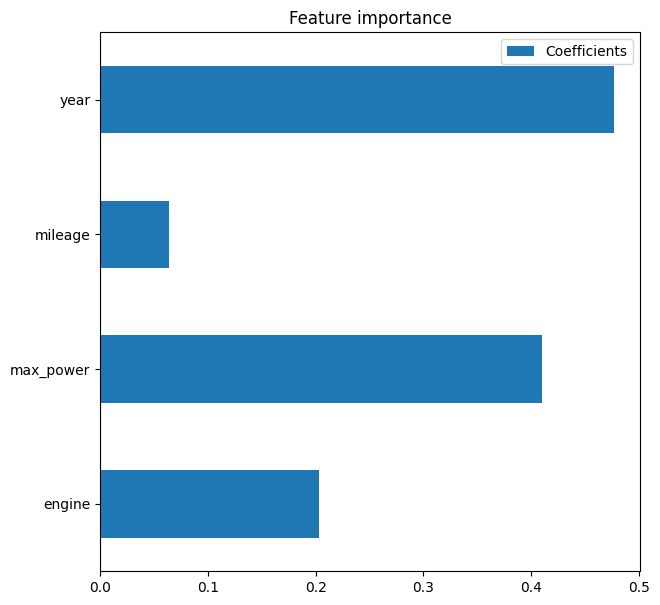

In [20]:
save_path = "mlruns/191373597521052669"
runs = os.listdir(save_path)

run_names = []
run_ids = []
mse_list = []
r2_list = []
runs.remove("meta.yaml")
import yaml
for rn in runs:
    if "test_mse" in os.listdir(save_path+"/"+rn+"/metrics"):
        with open(save_path+"/"+rn+"/meta.yaml", "r") as file:
            meta_data = yaml.safe_load(file)

        run_name = meta_data.get('run_name')
        run_id = meta_data.get('run_id')
        run_names.append(run_name)
        run_ids.append(run_id)

        with open(save_path+"/"+rn+"/metrics/test_mse", "r") as file:
            mse = file.read().split(' ')[1]

        mse_list.append(mse)

        with open(save_path+"/"+rn+"/metrics/test_r2", "r") as file:
            r2 = file.read().split(' ')[1]

        r2_list.append(r2)
        


max_index = r2_list.index(max(r2_list))
loaded_model = mlflow.sklearn.load_model(f'runs:/{run_ids[max_index]}/model')
print(run_names[max_index])
print("mse: ",mse_list[max_index],"r2: ",r2_list[max_index])
loaded_model.plot_coef()

## after this is some other experiment

### 1. compare "Polynomial","Ridge", "Lasso","Normal"

poly after scale

poly before scale

===== Polynomial =====


Fold 0: 0.091730757705533
Fold 1: 0.10448524162773429
Fold 2: 0.09286617875014616
Test MSE:  76685590458.24094
Test R2:  0.8686951405837193


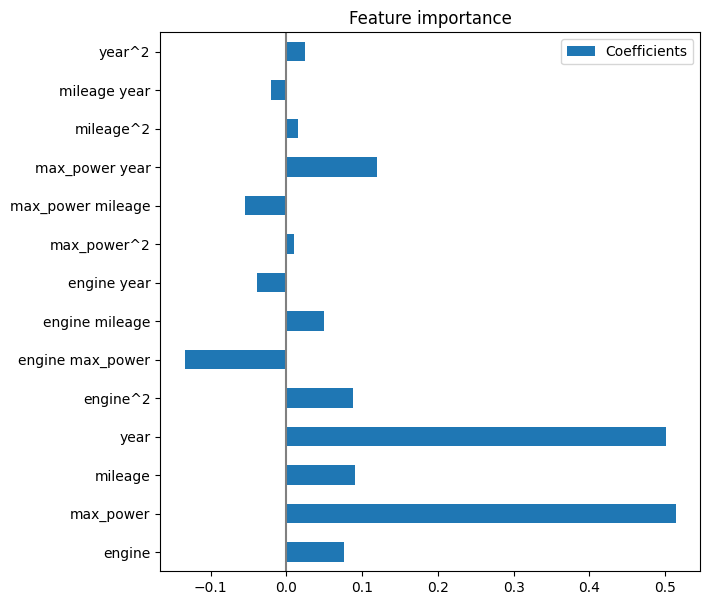

===== Ridge =====
Fold 0: 0.2991908662510607
Fold 1: 0.31517688768624114
Fold 2: 0.30509242771365774
Test MSE:  253258814013.12347
Test R2:  -0.4526914058739393


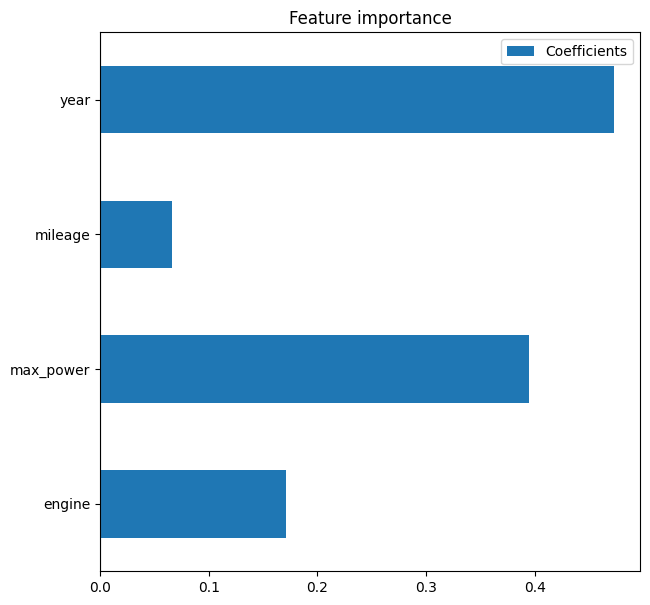

c:\Users\ASUS\anaconda3\envs\ML_env\lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\ASUS\anaconda3\envs\ML_env\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


===== Lasso =====
Fold 0: 0.11464014163673003
Fold 1: 0.11911870391883705
Fold 2: 0.11406352621655065
Test MSE:  154342917464.08636
Test R2:  0.4130368202369149


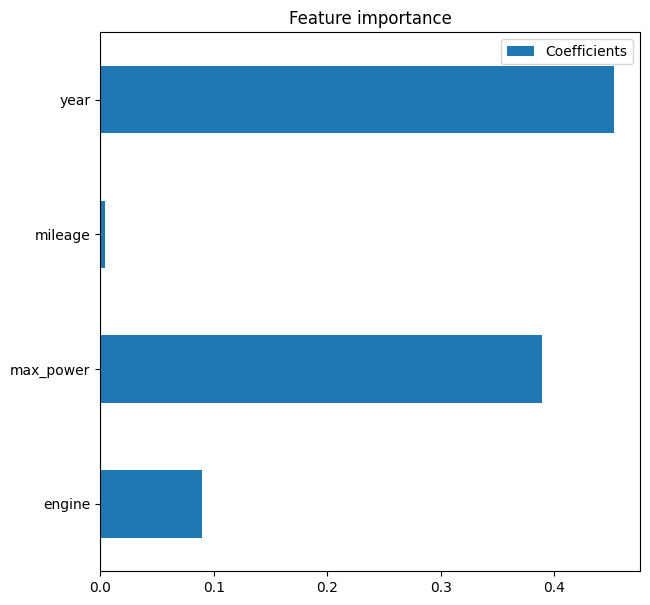

c:\Users\ASUS\anaconda3\envs\ML_env\lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\ASUS\anaconda3\envs\ML_env\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


===== Normal =====
Fold 0: 0.10609119810798341
Fold 1: 0.10170052407288924
Fold 2: 0.09917518442544128
Test MSE:  145998218028.8284
Test R2:  0.698986974313474


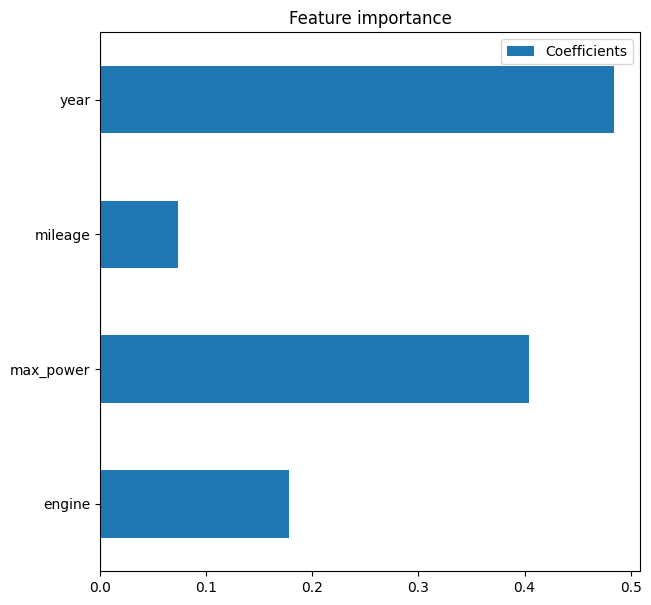

c:\Users\ASUS\anaconda3\envs\ML_env\lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\ASUS\anaconda3\envs\ML_env\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [11]:
# default value
table = {"name":[],
            "mse":[],
            "r2":[]}


reg = "Normal" # "Polynomial","Ridge","Lasso","Normal"
lr = 0.06 # 0.01, 0.001, 0.0001
l = 0.06
method = "batch" # "batch", "mini", "sto"
p_degree = 2
momentum = 0.1 
init_method = "xavier" # xavier, "zero"
patience = 10
num_epochs = 1000

# experiments list
experiments = ["Polynomial","Ridge","Lasso","Normal"]

# change here
for reg in experiments:
    
    # change here
    print("="*5, reg, "="*5)
    table["name"].append(reg)



    params = {"method": method, "lr": lr, "l": l,"momentum": momentum,"initw":init_method,"patience":patience,"num_epochs":num_epochs}

    if reg == "Polynomial":
        run_name = f"method-{params['method']}-lr-{params['lr']}-momentum-{params['momentum']}-initw-{params['initw']}-reg-Polynomial-degree-{p_degree}"
    else:
        run_name = f"method-{params['method']}-lr-{params['lr']}-momentum-{params['momentum']}-initw-{params['initw']}-reg-{reg}"
        
    mlflow.start_run(run_name=run_name, nested=True)

    # #######
    if reg == "Polynomial":


        poly = PolynomialFeatures(degree = p_degree, include_bias=True)
        X_train_tran = poly.fit_transform(X_train[:,1:])
        X_test_tran = poly.fit_transform(X_test[:,1:])
        feature_names_tran = poly.get_feature_names_out(feature_names)[1:]

    else:
        
        X_train_tran = X_train.copy()   
        X_test_tran = X_test.copy()
        feature_names_tran = feature_names


    # 
    if reg == "Ridge":
        params["l"] = params["l"]*0.3
        

    


    type_of_regression = str_to_class(reg)    #Ridge, Lasso, ElasticNet
    model = type_of_regression(**params)


    model.fit(X_train_tran, y_train,feature_names_tran)



    yhat = model.predict(X_test_tran)
    yhat = np.exp(yhat)
    mse  = model.mse(yhat, y_test)
    r2  = model.r2(yhat, y_test)

    print("Test MSE: ", mse)
    print("Test R2: ", r2)

    table["mse"].append(mse)
    table["r2"].append(r2)
    model.plot_coef()


    mlflow.log_metric(key="test_mse", value=mse)
    mlflow.log_metric(key="test_r2", value=r2)

    signature = mlflow.models.infer_signature(X_train_tran, model.predict(X_train_tran))
    mlflow.sklearn.log_model(model, artifact_path='model', signature=signature)

    # #######

    mlflow.end_run()



In [12]:
df_result = pd.DataFrame(table)
tables.append(df_result)
df_result

,name,mse,r2
0,Polynomial,7.668559e+10,0.868695
1,Ridge,2.532588e+11,-0.452691
2,Lasso,1.543429e+11,0.413037
3,Normal,1.459982e+11,0.698987


### 2. momentums and no momentum

===== m =  0 =====
Fold 0: 0.09134655166880433
Fold 1: 0.10425829795472871
Fold 2: 0.09248901479350048
Test MSE:  77289744621.78282
Test R2:  0.8674698621540134


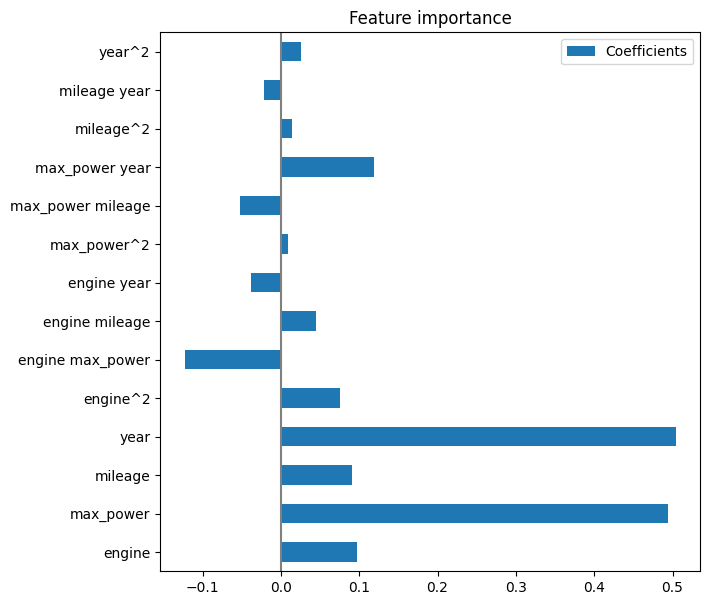

c:\Users\ASUS\anaconda3\envs\ML_env\lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\ASUS\anaconda3\envs\ML_env\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


===== m =  0.1 =====
Fold 0: 0.09143671460479032
Fold 1: 0.10460615834471595
Fold 2: 0.09290775047184924
Test MSE:  76700080800.4077
Test R2:  0.8687309137642703


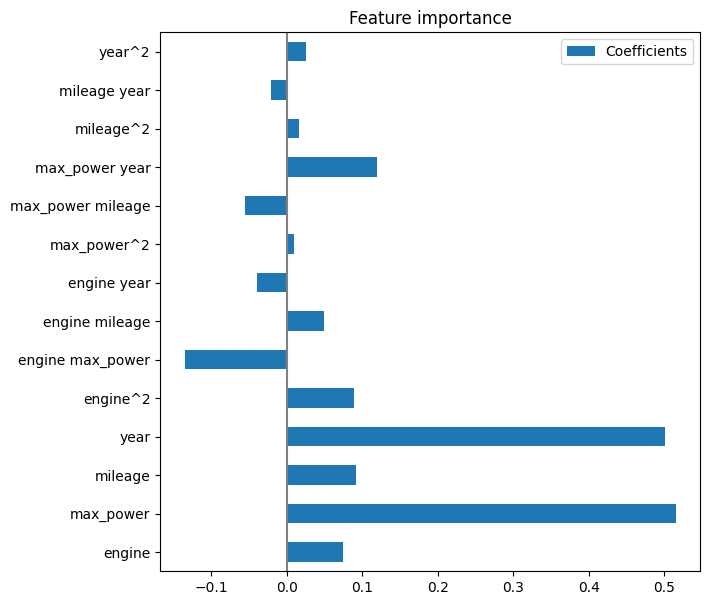

c:\Users\ASUS\anaconda3\envs\ML_env\lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\ASUS\anaconda3\envs\ML_env\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


===== m =  0.3 =====
Fold 0: 0.09389449462981511
Fold 1: 0.10783579245149637
Fold 2: 0.09487311230766024
Test MSE:  78700035758.69675
Test R2:  0.8675297815975667


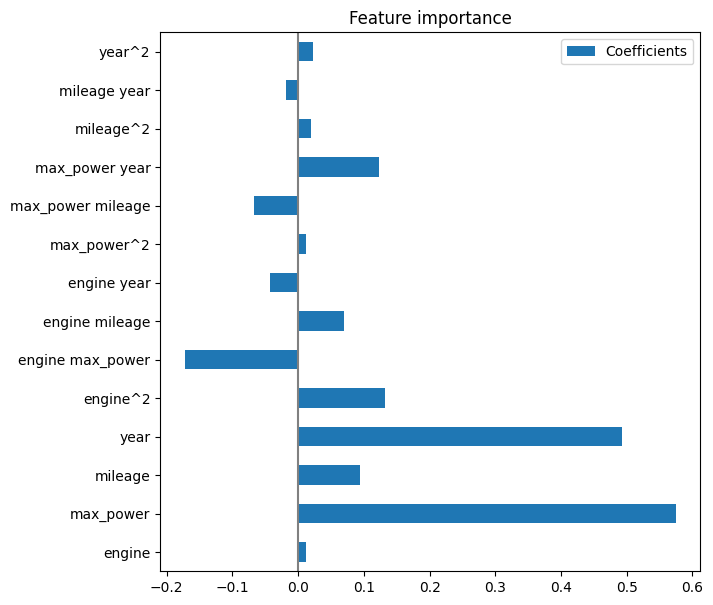

c:\Users\ASUS\anaconda3\envs\ML_env\lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\ASUS\anaconda3\envs\ML_env\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [14]:
# default value
table = {"name":[],
            "mse":[],
            "r2":[]}


reg = "Polynomial" # "Polynomial","Ridge","Lasso","Normal"
lr = 0.06 # 0.01, 0.001, 0.0001
l = 0.06
method = "batch" # "batch", "mini", "sto"
p_degree = 2
momentum = 0.1 
init_method = "xavier" # xavier, "zero"
patience = 10
num_epochs = 1000

# experiments list
experiments = [0,0.1,0.3]

# change here
for momentum in experiments:

    print("="*5, "m = ", momentum, "="*5)
    table["name"].append(momentum)



    params = {"method": method, "lr": lr, "l": l,"momentum": momentum,"initw":init_method,"patience":patience,"num_epochs":num_epochs}

    if reg == "Polynomial":
        run_name = f"method-{params['method']}-lr-{params['lr']}-momentum-{params['momentum']}-initw-{params['initw']}-reg-Polynomial-degree-{p_degree}"
    else:
        run_name = f"method-{params['method']}-lr-{params['lr']}-momentum-{params['momentum']}-initw-{params['initw']}-reg-{reg}"
        
    mlflow.start_run(run_name=run_name, nested=True)

    # #######
    if reg == "Polynomial":


        poly = PolynomialFeatures(degree = p_degree, include_bias=True)
        X_train_tran = poly.fit_transform(X_train[:,1:])
        X_test_tran = poly.fit_transform(X_test[:,1:])
        feature_names_tran = poly.get_feature_names_out(feature_names)[1:]

    else:
        
        X_train_tran = X_train.copy()   
        X_test_tran = X_test.copy()
        feature_names_tran = feature_names


    # 
    if reg == "Ridge":
        params["l"] = params["l"]*0.3
        

    


    type_of_regression = str_to_class(reg)    #Ridge, Lasso, ElasticNet
    model = type_of_regression(**params)


    model.fit(X_train_tran, y_train,feature_names_tran)



    yhat = model.predict(X_test_tran)
    yhat = np.exp(yhat)
    mse  = model.mse(yhat, y_test)
    r2  = model.r2(yhat, y_test)

    print("Test MSE: ", mse)
    print("Test R2: ", r2)

    table["mse"].append(mse)
    table["r2"].append(r2)
    model.plot_coef()


    mlflow.log_metric(key="test_mse", value=mse)
    mlflow.log_metric(key="test_r2", value=r2)

    signature = mlflow.models.infer_signature(X_train_tran, model.predict(X_train_tran))
    mlflow.sklearn.log_model(model, artifact_path='model', signature=signature)

    # #######

    mlflow.end_run()



In [15]:
df_result = pd.DataFrame(table)
tables.append(df_result)
df_result

,name,mse,r2
0,0.0,7.728974e+10,0.867470
1,0.1,7.670008e+10,0.868731
2,0.3,7.870004e+10,0.867530


### 3. gradient 'sto',"mini","batch"

===== batch =====
Fold 0: 0.10609120740462842
Fold 1: 0.10170051991232663
Fold 2: 0.09917519349805871
Test MSE:  145998190477.63507
Test R2:  0.698987377291987


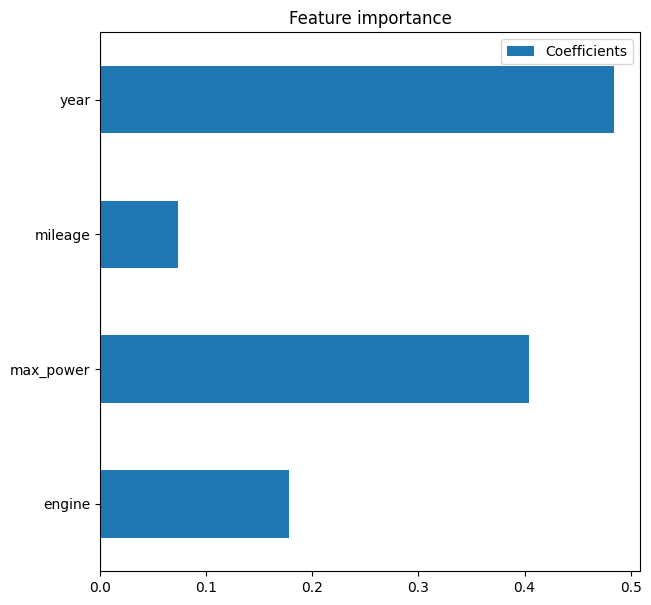

c:\Users\ASUS\anaconda3\envs\ML_env\lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\ASUS\anaconda3\envs\ML_env\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


===== mini =====
Fold 0: 0.10627643985892055
Fold 1: 0.10172794448614421
Fold 2: 0.09943639862280153
Test MSE:  140835101379.40417
Test R2:  0.6952004613760331


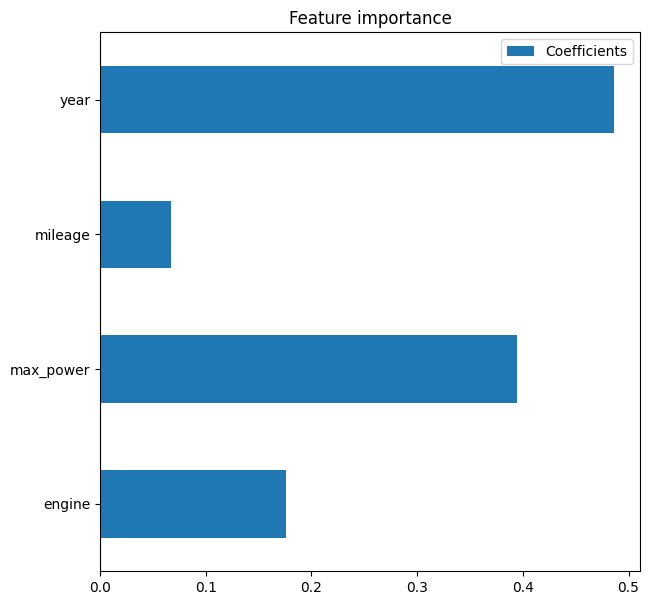

c:\Users\ASUS\anaconda3\envs\ML_env\lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\ASUS\anaconda3\envs\ML_env\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


===== sto =====
Fold 0: 0.15991052499273503
Fold 1: 0.11059790796811081
Fold 2: 0.13612382462141723
Test MSE:  199703830371.37277
Test R2:  -0.11186892244469893


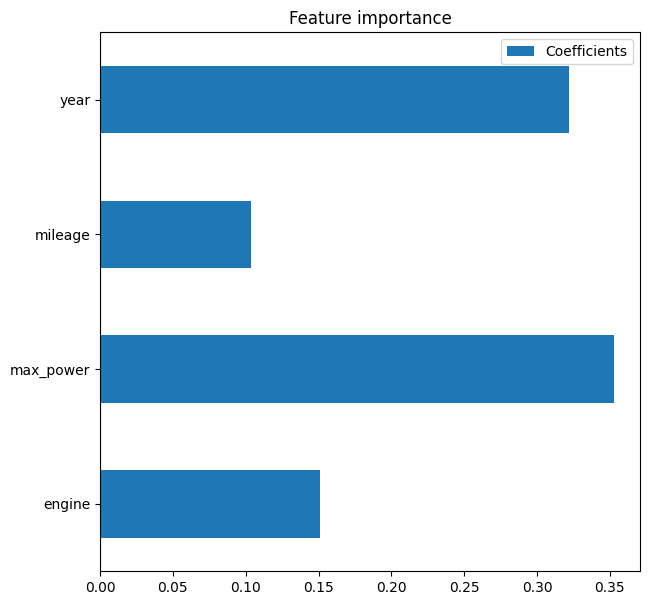

c:\Users\ASUS\anaconda3\envs\ML_env\lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\ASUS\anaconda3\envs\ML_env\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [16]:
# default value
table = {"name":[],
            "mse":[],
            "r2":[]}


reg = "Normal" # "Polynomial","Ridge","Lasso","Normal"
lr = 0.06 # 0.01, 0.001, 0.0001
l = 0.06
method = "batch" # "batch", "mini", "sto"
p_degree = 2
momentum = 0.1 
init_method = "xavier" # xavier, "zero"
patience = 10
num_epochs = 1000

# experiments list
experiments = ["batch", "mini", "sto"]

# change here
for method in experiments:

    print("="*5, method, "="*5)
    table["name"].append(method)



    params = {"method": method, "lr": lr, "l": l,"momentum": momentum,"initw":init_method,"patience":patience,"num_epochs":num_epochs}

    if reg == "Polynomial":
        run_name = f"method-{params['method']}-lr-{params['lr']}-momentum-{params['momentum']}-initw-{params['initw']}-reg-Polynomial-degree-{p_degree}"
    else:
        run_name = f"method-{params['method']}-lr-{params['lr']}-momentum-{params['momentum']}-initw-{params['initw']}-reg-{reg}"
        
    mlflow.start_run(run_name=run_name, nested=True)

    # #######
    if reg == "Polynomial":


        poly = PolynomialFeatures(degree = p_degree, include_bias=True)
        X_train_tran = poly.fit_transform(X_train[:,1:])
        X_test_tran = poly.fit_transform(X_test[:,1:])
        feature_names_tran = poly.get_feature_names_out(feature_names)[1:]

    else:
        
        X_train_tran = X_train.copy()   
        X_test_tran = X_test.copy()
        feature_names_tran = feature_names


    # 
    if reg == "Ridge":
        params["l"] = params["l"]*0.3
        

    


    type_of_regression = str_to_class(reg)    #Ridge, Lasso, ElasticNet
    model = type_of_regression(**params)


    model.fit(X_train_tran, y_train,feature_names_tran)



    yhat = model.predict(X_test_tran)
    yhat = np.exp(yhat)
    mse  = model.mse(yhat, y_test)
    r2  = model.r2(yhat, y_test)

    print("Test MSE: ", mse)
    print("Test R2: ", r2)

    table["mse"].append(mse)
    table["r2"].append(r2)
    model.plot_coef()


    mlflow.log_metric(key="test_mse", value=mse)
    mlflow.log_metric(key="test_r2", value=r2)

    signature = mlflow.models.infer_signature(X_train_tran, model.predict(X_train_tran))
    mlflow.sklearn.log_model(model, artifact_path='model', signature=signature)

    # #######

    mlflow.end_run()



In [17]:
df_result = pd.DataFrame(table)
tables.append(df_result)
df_result

,name,mse,r2
0,batch,1.459982e+11,0.698987
1,mini,1.408351e+11,0.695200
2,sto,1.997038e+11,-0.111869


### 4. initw_method "xavier" or "zero"

===== zero =====
Fold 0: 0.0915700390612027
Fold 1: 0.10456634164631604
Fold 2: 0.09289030767628435
Test MSE:  76752138961.4114
Test R2:  0.8686569263906957


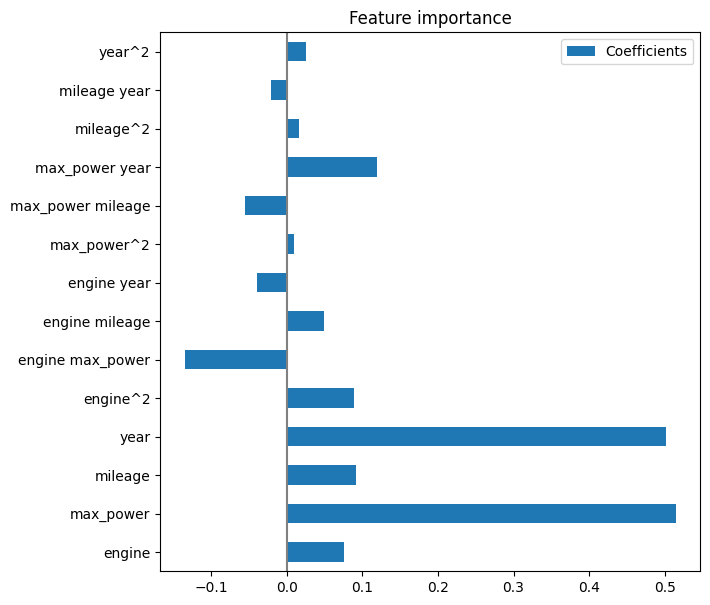

c:\Users\ASUS\anaconda3\envs\ML_env\lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\ASUS\anaconda3\envs\ML_env\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


===== xavier =====
Fold 0: 0.09154777533086055
Fold 1: 0.10301945124613729
Fold 2: 0.0929951567589178
Test MSE:  76595263615.68929
Test R2:  0.8689369210551734


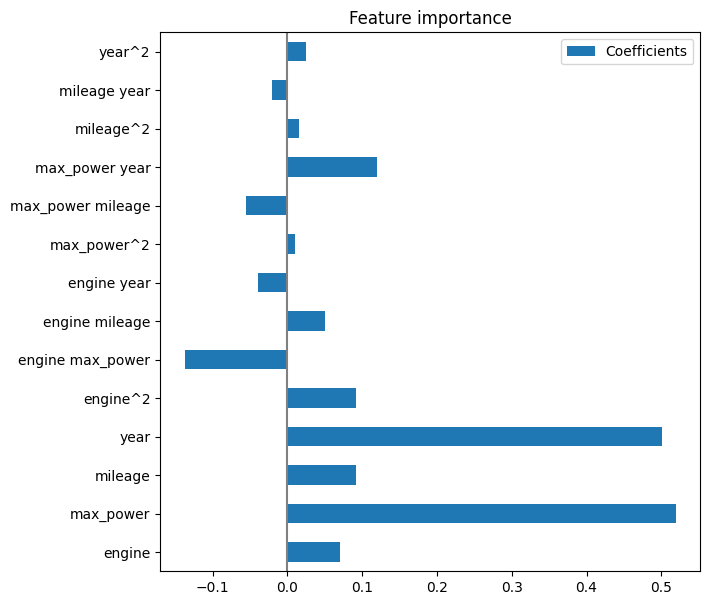

c:\Users\ASUS\anaconda3\envs\ML_env\lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\ASUS\anaconda3\envs\ML_env\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [18]:


# default value
table = {"name":[],
            "mse":[],
            "r2":[]}


reg = "Polynomial" # "Polynomial","Ridge","Lasso","Normal"
lr = 0.06 # 0.01, 0.001, 0.0001
l = 0.06
method = "batch" # "batch", "mini", "sto"
p_degree = 2
momentum = 0.1 
init_method = "xavier" # xavier, "zero"
patience = 10
num_epochs = 1000

# experiments list
experiments = ["zero", "xavier"]

# change here
for init_method in experiments:

    print("="*5, init_method, "="*5)

    table["name"].append(init_method)



    params = {"method": method, "lr": lr, "l": l,"momentum": momentum,"initw":init_method,"patience":patience,"num_epochs":num_epochs}

    if reg == "Polynomial":
        run_name = f"method-{params['method']}-lr-{params['lr']}-momentum-{params['momentum']}-initw-{params['initw']}-reg-Polynomial-degree-{p_degree}"
    else:
        run_name = f"method-{params['method']}-lr-{params['lr']}-momentum-{params['momentum']}-initw-{params['initw']}-reg-{reg}"
        
    mlflow.start_run(run_name=run_name, nested=True)

    # #######
    if reg == "Polynomial":


        poly = PolynomialFeatures(degree = p_degree, include_bias=True)
        X_train_tran = poly.fit_transform(X_train[:,1:])
        X_test_tran = poly.fit_transform(X_test[:,1:])
        feature_names_tran = poly.get_feature_names_out(feature_names)[1:]

    else:
        
        X_train_tran = X_train.copy()   
        X_test_tran = X_test.copy()
        feature_names_tran = feature_names


    # 
    if reg == "Ridge":
        params["l"] = params["l"]*0.3
        

    


    type_of_regression = str_to_class(reg)    #Ridge, Lasso, ElasticNet
    model = type_of_regression(**params)


    model.fit(X_train_tran, y_train,feature_names_tran)



    yhat = model.predict(X_test_tran)
    yhat = np.exp(yhat)
    mse  = model.mse(yhat, y_test)
    r2  = model.r2(yhat, y_test)

    print("Test MSE: ", mse)
    print("Test R2: ", r2)

    table["mse"].append(mse)
    table["r2"].append(r2)
    model.plot_coef()


    mlflow.log_metric(key="test_mse", value=mse)
    mlflow.log_metric(key="test_r2", value=r2)

    signature = mlflow.models.infer_signature(X_train_tran, model.predict(X_train_tran))
    mlflow.sklearn.log_model(model, artifact_path='model', signature=signature)

    # #######

    mlflow.end_run()



In [19]:
df_result = pd.DataFrame(table)
tables.append(df_result)
df_result

,name,mse,r2
0,zero,7.675214e+10,0.868657
1,xavier,7.659526e+10,0.868937


### 5. lr = [0.01, 0.001, 0.0001]

===== lr =  0.01 =====
Fold 0: 0.3814820143712338
Fold 1: 0.3484708151626668
Fold 2: 0.2591548155600332
Test MSE:  10781846541145.521
Test R2:  0.11234145454264632


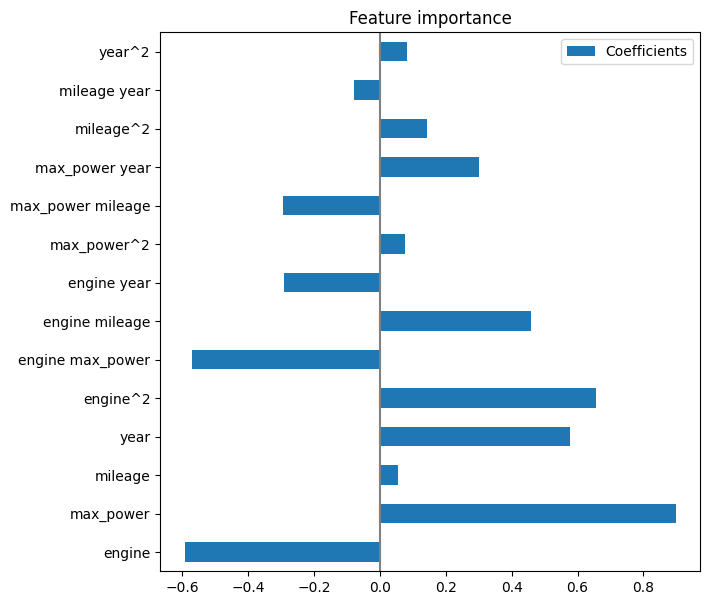

c:\Users\ASUS\anaconda3\envs\ML_env\lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\ASUS\anaconda3\envs\ML_env\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


===== lr =  0.001 =====
Fold 0: 33.00919632467022
Fold 1: 31.5567705213828
Fold 2: 25.5702463300392
Test MSE:  2.552120259394569e+36
Test R2:  -0.0005009610689412636


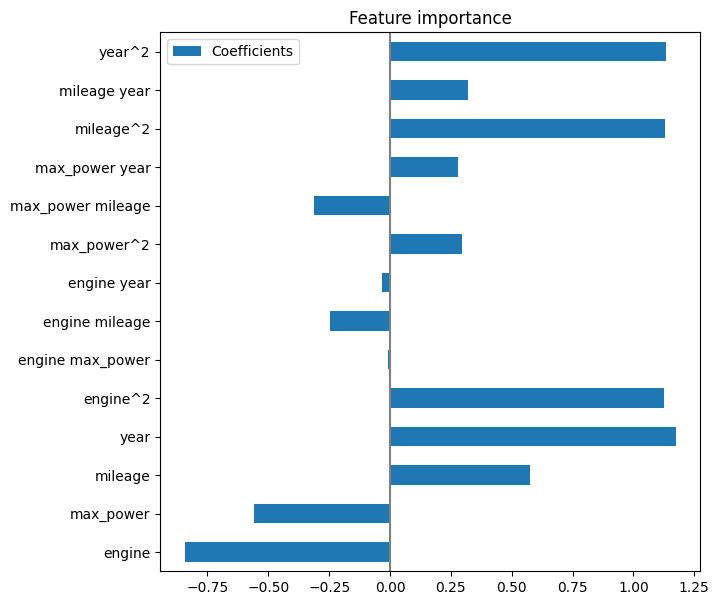

c:\Users\ASUS\anaconda3\envs\ML_env\lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\ASUS\anaconda3\envs\ML_env\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


===== lr =  0.0001 =====
Fold 0: 87.51723668567517
Fold 1: 89.70597616191124
Fold 2: 83.74860522899687
Test MSE:  2.687588657810485e+38
Test R2:  -0.0008334607265192417


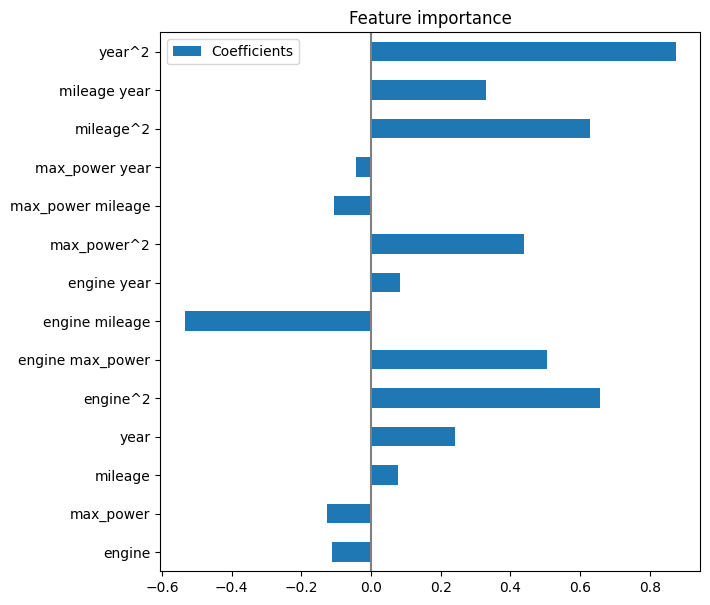

c:\Users\ASUS\anaconda3\envs\ML_env\lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\ASUS\anaconda3\envs\ML_env\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [20]:
# default value
table = {"name":[],
            "mse":[],
            "r2":[]}


reg = "Polynomial" # "Polynomial","Ridge","Lasso","Normal"
lr = 0.06 # 0.01, 0.001, 0.0001
l = 0.06
method = "batch" # "batch", "mini", "sto"
p_degree = 2
momentum = 0.1 
init_method = "xavier" # xavier, "zero"
patience = 10
num_epochs = 1000

# experiments list
experiments = [0.01, 0.001, 0.0001]

# change here
for lr in experiments:

    print("="*5, "lr = ", lr, "="*5)
    table["name"].append(lr)



    params = {"method": method, "lr": lr, "l": l,"momentum": momentum,"initw":init_method,"patience":patience,"num_epochs":num_epochs}

    if reg == "Polynomial":
        run_name = f"method-{params['method']}-lr-{params['lr']}-momentum-{params['momentum']}-initw-{params['initw']}-reg-Polynomial-degree-{p_degree}"
    else:
        run_name = f"method-{params['method']}-lr-{params['lr']}-momentum-{params['momentum']}-initw-{params['initw']}-reg-{reg}"
        
    mlflow.start_run(run_name=run_name, nested=True)

    # #######
    if reg == "Polynomial":


        poly = PolynomialFeatures(degree = p_degree, include_bias=True)
        X_train_tran = poly.fit_transform(X_train[:,1:])
        X_test_tran = poly.fit_transform(X_test[:,1:])
        feature_names_tran = poly.get_feature_names_out(feature_names)[1:]

    else:
        
        X_train_tran = X_train.copy()   
        X_test_tran = X_test.copy()
        feature_names_tran = feature_names


    # 
    if reg == "Ridge":
        params["l"] = params["l"]*0.3
        

    


    type_of_regression = str_to_class(reg)    #Ridge, Lasso, ElasticNet
    model = type_of_regression(**params)


    model.fit(X_train_tran, y_train,feature_names_tran)



    yhat = model.predict(X_test_tran)
    yhat = np.exp(yhat)
    mse  = model.mse(yhat, y_test)
    r2  = model.r2(yhat, y_test)

    print("Test MSE: ", mse)
    print("Test R2: ", r2)

    table["mse"].append(mse)
    table["r2"].append(r2)
    model.plot_coef()


    mlflow.log_metric(key="test_mse", value=mse)
    mlflow.log_metric(key="test_r2", value=r2)

    signature = mlflow.models.infer_signature(X_train_tran, model.predict(X_train_tran))
    mlflow.sklearn.log_model(model, artifact_path='model', signature=signature)

    # #######

    mlflow.end_run()



In [21]:
df_result = pd.DataFrame(table)
tables.append(df_result)
df_result

,name,mse,r2
0,0.0100,1.078185e+13,0.112341
1,0.0010,2.552120e+36,-0.000501
2,0.0001,2.687589e+38,-0.000833


may be low lr is not good for poly let see ridge, this time i will set it's l to 0.01

===== lr =  0.01 =====
Fold 0: 0.6322693874929516
Fold 1: 0.6595475079406484
Fold 2: 0.6446507792742748
Test MSE:  374238996639.67773
Test R2:  -3.058264802189436


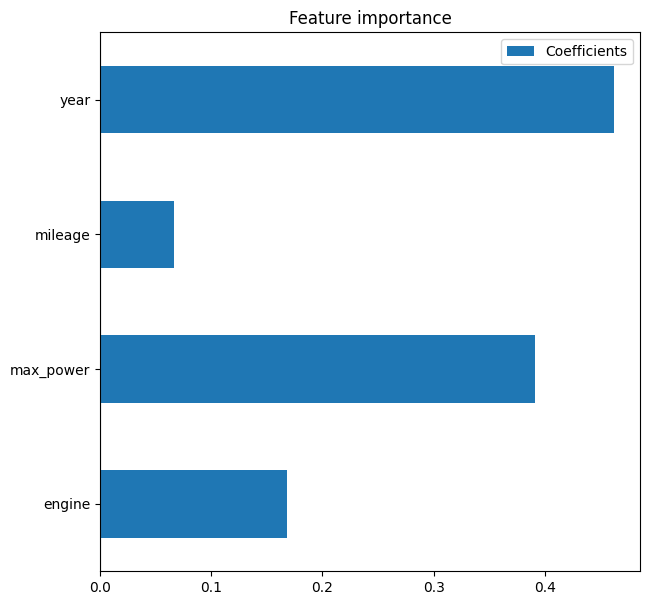

c:\Users\ASUS\anaconda3\envs\ML_env\lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\ASUS\anaconda3\envs\ML_env\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


===== lr =  0.001 =====
Fold 0: 29.371142724893552
Fold 1: 31.453371275394257
Fold 2: 28.86221322773104
Test MSE:  938062201620.1064
Test R2:  -190582.0851537458


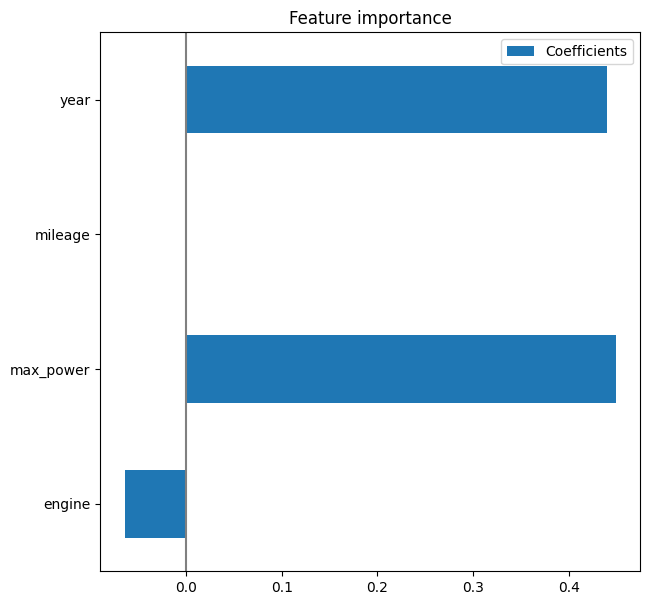

c:\Users\ASUS\anaconda3\envs\ML_env\lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\ASUS\anaconda3\envs\ML_env\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


===== lr =  0.0001 =====
Fold 0: 138.36245984960408
Fold 1: 132.4105186104818
Fold 2: 144.1559680111315
Test MSE:  944208729339.6792
Test R2:  -1083508597446.8326


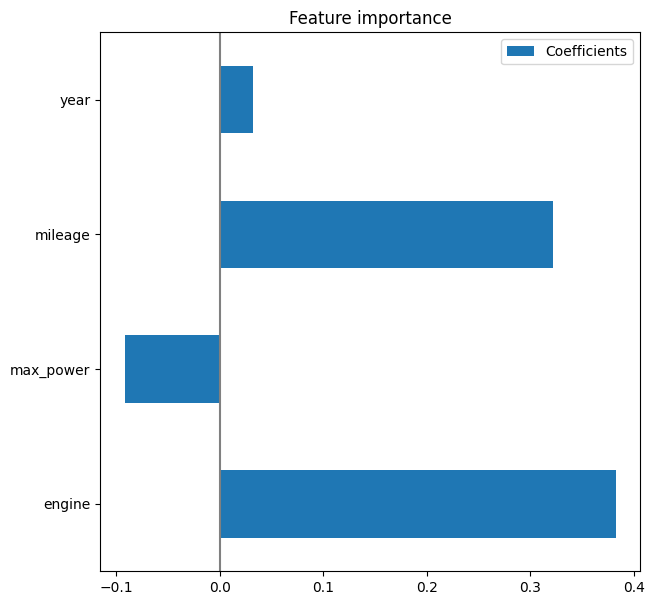

c:\Users\ASUS\anaconda3\envs\ML_env\lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\ASUS\anaconda3\envs\ML_env\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [24]:
# default value
table = {"name":[],
            "mse":[],
            "r2":[]}


reg = "Ridge" # "Polynomial","Ridge","Lasso","Normal"
lr = 0.06 # 0.01, 0.001, 0.0001
l = 0.1
method = "batch" # "batch", "mini", "sto"
p_degree = 2
momentum = 0.1 
init_method = "xavier" # xavier, "zero"
patience = 10
num_epochs = 1000

# experiments list
experiments = [0.01, 0.001, 0.0001]

# change here
for lr in experiments:

    print("="*5, "lr = ", lr, "="*5)
    table["name"].append(str(lr)+"-Ridge")



    params = {"method": method, "lr": lr, "l": l,"momentum": momentum,"initw":init_method,"patience":patience,"num_epochs":num_epochs}

    if reg == "Polynomial":
        run_name = f"method-{params['method']}-lr-{params['lr']}-momentum-{params['momentum']}-initw-{params['initw']}-reg-Polynomial-degree-{p_degree}"
    else:
        run_name = f"method-{params['method']}-lr-{params['lr']}-momentum-{params['momentum']}-initw-{params['initw']}-reg-{reg}"
        
    mlflow.start_run(run_name=run_name, nested=True)

    # #######
    if reg == "Polynomial":


        poly = PolynomialFeatures(degree = p_degree, include_bias=True)
        X_train_tran = poly.fit_transform(X_train[:,1:])
        X_test_tran = poly.fit_transform(X_test[:,1:])
        feature_names_tran = poly.get_feature_names_out(feature_names)[1:]

    else:
        
        X_train_tran = X_train.copy()   
        X_test_tran = X_test.copy()
        feature_names_tran = feature_names


    # 
    if reg == "Ridge":
        params["l"] = params["l"]*0.3
        

    


    type_of_regression = str_to_class(reg)    #Ridge, Lasso, ElasticNet
    model = type_of_regression(**params)


    model.fit(X_train_tran, y_train,feature_names_tran)



    yhat = model.predict(X_test_tran)
    yhat = np.exp(yhat)
    mse  = model.mse(yhat, y_test)
    r2  = model.r2(yhat, y_test)

    print("Test MSE: ", mse)
    print("Test R2: ", r2)

    table["mse"].append(mse)
    table["r2"].append(r2)
    model.plot_coef()


    mlflow.log_metric(key="test_mse", value=mse)
    mlflow.log_metric(key="test_r2", value=r2)

    signature = mlflow.models.infer_signature(X_train_tran, model.predict(X_train_tran))
    mlflow.sklearn.log_model(model, artifact_path='model', signature=signature)

    # #######

    mlflow.end_run()



In [25]:
df_result = pd.DataFrame(table)
tables.append(df_result)
df_result

,name,mse,r2
0,0.01-Ridge,3.742390e+11,-3.058265e+00
1,0.001-Ridge,9.380622e+11,-1.905821e+05
2,0.0001-Ridge,9.442087e+11,-1.083509e+12


lol lower learning rate make it really bad

## inference example

In [27]:
run_ids ="55a79d69b2624c3da291e211c2328c92"
loaded_model = mlflow.sklearn.load_model(f'runs:/{run_ids}/model')

## summary

I think the issue for ridge and losso maybe it cause the learning to be slower and make it need more epoch to learn (or maybe it worse no matter what),and it also can see on the learning rate experiment that lower the learning rate gave the worse result.   
   
 For polynomial tranform, It show that it give the good result when i do polynomial tranform after scale which I don't think it a correct ways since scaling should only affect the speed and no related to performance and I don't know why, but the fact that it gave the best result doesn't change.
    
For momentum, I think my code is correct but it almost have no affect (except i use high number and r2 go -inf)

![!\[img\](figures/screen.png)](figures/Screenshot_ML-flow.png)

In [26]:

df_all = pd.concat(tables)
df_all

,name,mse,r2
0,Polynomial,7.668559e+10,8.686951e-01
1,Ridge,2.532588e+11,-4.526914e-01
2,Lasso,1.543429e+11,4.130368e-01
3,Normal,1.459982e+11,6.989870e-01
0,0.0,7.728974e+10,8.674699e-01
1,0.1,7.670008e+10,8.687309e-01
2,0.3,7.870004e+10,8.675298e-01
0,batch,1.459982e+11,6.989874e-01
1,mini,1.408351e+11,6.952005e-01
2,sto,1.997038e+11,-1.118689e-01


I belive method-sto-lr-0.01-momentum-0-initw-xavier-reg-Normal is the best if we not count polynomial after scale with xavier lr = 0.06 